In [2]:
import pandas as pd
import numpy as np
import datetime
import talib
from wmpy.trader.utility import get_previous_date, load_tick
from wmpy.app.cta_backtester.backtesting_tick import cal_all_pnl, cal_daily_pnl # 注意这里是backtesting_tick

In [3]:
date = 20210105
contract = 'IF2101'
tick_df = load_tick(contract, date)

parameter_dict = dict(N=5,K=2)

N = parameter_dict['N']
K = parameter_dict['K']

In [4]:
tick_df

,symbol,volume,open_interest,amount,last_price,bid_price_1,ask_price_1,bid_volume_1,ask_volume_1
datetime,,,,,,,,,
2021-01-05 09:30:00.200,IF2101,196.0,84387.0,3.086968e+08,5249.8,5249.2,5249.4,2.0,28.0
2021-01-05 09:30:00.700,IF2101,303.0,84303.0,4.771681e+08,5246.6,5246.6,5249.0,1.0,23.0
2021-01-05 09:30:01.200,IF2101,402.0,84240.0,6.330197e+08,5246.0,5246.0,5246.6,1.0,7.0
2021-01-05 09:30:01.700,IF2101,447.0,84206.0,7.038437e+08,5246.0,5246.4,5248.0,3.0,2.0
2021-01-05 09:30:02.200,IF2101,464.0,84194.0,7.306017e+08,5247.0,5245.6,5246.0,20.0,5.0
...,...,...,...,...,...,...,...,...,...
2021-01-05 14:59:58.200,IF2101,88189.0,85959.0,1.403911e+11,5360.6,5359.0,5359.8,2.0,1.0
2021-01-05 14:59:58.700,IF2101,88191.0,85960.0,1.403943e+11,5359.8,5359.0,5360.0,3.0,1.0
2021-01-05 14:59:59.200,IF2101,88193.0,85962.0,1.403976e+11,5359.8,5359.8,5360.0,10.0,1.0


In [6]:
temp_df = tick_df.copy()
# 买量-卖量
array0 = (temp_df['bid_price_1']-temp_df['ask_price_1'])/(temp_df['bid_price_1']+temp_df['ask_price_1'])
temp_df['factor0'] = talib.EMA(array0, N)
# volume_diff
array1 = np.sign(temp_df['bid_price_1'].diff())-np.sign(temp_df['ask_price_1'].diff())
temp_df['factor1'] = talib.EMA(array1, N)
# ma_diff
temp_df['mid'] = (temp_df['bid_price_1']+temp_df['ask_price_1'])/2
temp_df['factor2'] = (talib.SMA(temp_df['mid'],N/K)-talib.SMA(temp_df['mid'],N))/temp_df['mid']
# ma_diff改
temp_df['factor3'] = (talib.SMA(temp_df['mid'],N/K)-talib.SMA(temp_df['mid'],N))/(temp_df['mid'].rolling(N).max()-temp_df['mid'].rolling(N).min())
temp_df['factor3'] = temp_df['factor3'].rolling(1).sum()
# 均价位置
temp_df['volume_diff'] = temp_df['volume'].diff()
temp_df['amount_diff'] = temp_df['amount'].diff()
temp_df['avg_price'] = temp_df['amount_diff'] / temp_df['volume_diff'] / 300
array4 = np.where(temp_df['avg_price'] < temp_df['bid_price_1'], -1, np.where(temp_df['avg_price'] > temp_df['ask_price_1'], 1, 0))
array4 = np.array(array4,dtype = float)
temp_df['factor4'] = talib.EMA(array4,N)
# 趋势程度
temp_df['trend'] = (temp_df['mid']-temp_df['mid'].shift(N))/(temp_df['mid'].rolling(N).max()-temp_df['mid'].rolling(N).min())
temp_df['factor5'] = abs(temp_df['trend'])
temp_df['factor5'] = temp_df['factor5'].rolling(1).sum()                    
# 标准差
temp_df['std'] = temp_df['mid'].rolling(N).std()
temp_df['factor6'] = talib.EMA(temp_df['std'],N)
# 第i个tick到i+5个tick的价格变动百分比
temp_df['rev'] = (temp_df['mid']-temp_df['mid'].shift(5))/temp_df['mid'].shift(5)

In [7]:
temp_df

,symbol,volume,open_interest,amount,last_price,bid_price_1,ask_price_1,bid_volume_1,ask_volume_1,factor0,...,factor3,volume_diff,amount_diff,avg_price,factor4,trend,factor5,std,factor6,rev
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-05 09:30:00.200,IF2101,196.0,84387.0,3.086968e+08,5249.8,5249.2,5249.4,2.0,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 09:30:00.700,IF2101,303.0,84303.0,4.771681e+08,5246.6,5246.6,5249.0,1.0,23.0,NaN,...,NaN,107.0,168471240.0,5248.325234,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 09:30:01.200,IF2101,402.0,84240.0,6.330197e+08,5246.0,5246.0,5246.6,1.0,7.0,NaN,...,NaN,99.0,155851680.0,5247.531313,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 09:30:01.700,IF2101,447.0,84206.0,7.038437e+08,5246.0,5246.4,5248.0,3.0,2.0,NaN,...,NaN,45.0,70823940.0,5246.217778,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 09:30:02.200,IF2101,464.0,84194.0,7.306017e+08,5247.0,5245.6,5246.0,20.0,5.0,-0.000099,...,-0.222857,17.0,26758020.0,5246.670588,0.200000,NaN,NaN,1.370036,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05 14:59:58.200,IF2101,88189.0,85959.0,1.403911e+11,5360.6,5359.0,5359.8,2.0,1.0,-0.000064,...,0.192857,9.0,14470140.0,5359.311111,-0.129785,0.357143,0.357143,0.563028,0.549343,0.000093
2021-01-05 14:59:58.700,IF2101,88191.0,85960.0,1.403943e+11,5359.8,5359.0,5360.0,3.0,1.0,-0.000074,...,-0.250000,2.0,3215640.0,5359.400000,-0.086523,0.600000,0.600000,0.430116,0.509601,0.000112
2021-01-05 14:59:59.200,IF2101,88193.0,85962.0,1.403976e+11,5359.8,5359.8,5360.0,10.0,1.0,-0.000056,...,0.020000,2.0,3215880.0,5359.800000,-0.057682,-0.100000,0.100000,0.414729,0.477977,-0.000019


In [8]:
# 计算各因子与价格变动百分比的相关系数
corr0 = temp_df['rev'].corr(temp_df['factor0'])
corr1= temp_df['rev'].corr(temp_df['factor1'])
corr2 = temp_df['rev'].corr(temp_df['factor2'])
corr3 = temp_df['rev'].corr(temp_df['factor3'])
corr4 = temp_df['rev'].corr(temp_df['factor4'])
corr5 = temp_df['rev'].corr(temp_df['factor5'])
corr6 = temp_df['rev'].corr(temp_df['factor6'])

In [9]:
corr = [corr0,corr1,corr2,corr3,corr4,corr5,corr6]

In [10]:
corr

[-0.012533005075679714,
 0.013005342696496152,
 0.8079602671387818,
 0.09854720660234145,
 -0.4130052826628788,
 -0.007584615939965185,
 0.006601763931077041]

In [11]:
# 发现factor2与价格变化之间存在明显正相关关系
# 利用factor2 设计tick 级策略

In [12]:
def factor2(tick_df, date, contract, parameter_dict=None):
    
    N = parameter_dict['N']
    K = parameter_dict['K']
    BUY_COEFFICIENT = parameter_dict['BUY_COEFFICIENT']
    SELL_COEFFICIENT = parameter_dict['SELL_COEFFICIENT']
    
    mid = (tick_df['bid_price_1'] + tick_df['ask_price_1']) / 2
    
    factor_ser = (talib.SMA(mid,N/K)-talib.SMA(mid,N))/mid
    
    score_ser = pd.Series(factor_ser, index=tick_df.index)
    
    BUY_OPEN_THRESHOLD =  BUY_COEFFICIENT* factor_ser.max()
    SELL_OPEN_THRESHOLD = SELL_COEFFICIENT* factor_ser.min()

    SELL_CLOSE_THRESHOLD = SELL_COEFFICIENT* factor_ser.min()
    BUY_CLOSE_THRESHOLD = BUY_COEFFICIENT* factor_ser.max()

   ## 根据信号确定仓位
    signal_ser = pd.Series(data=0, index=score_ser.index)



    ## 先确定开仓时点
    buy_open_bool = score_ser >= BUY_OPEN_THRESHOLD
    signal_ser[buy_open_bool] = 1

    sell_open_bool = score_ser <= SELL_OPEN_THRESHOLD
    signal_ser[sell_open_bool] = -1

    ## 再确定平仓时点
    buy_close_bool = score_ser <= SELL_CLOSE_THRESHOLD
    position_positive = pd.Series(data=np.nan, index=score_ser.index)
    position_positive.iloc[0] = 0
    position_positive[signal_ser == 1] = 1
    position_positive[buy_close_bool] = 0
    position_positive = position_positive.ffill()
    position_positive = position_positive.shift(1)

    sell_close_bool = score_ser >= BUY_CLOSE_THRESHOLD
    position_negative = pd.Series(data=np.nan, index=score_ser.index)
    position_negative.iloc[0] = 0
    position_negative[signal_ser == -1] = -1
    position_negative[sell_close_bool] = 0
    position_negative = position_negative.ffill()
    position_negative = position_negative.shift(1)

    position_ser = position_positive + position_negative

    ## 返回这段时间的持仓序列
    position_ser = position_ser.fillna(0)
    position_ser = pd.Series(position_ser, index=tick_df.index)
    # position_ser = position_ser.shift(1) # 若取消注释，代表延迟一个tick成交
    position_ser.loc[: N-1] = 0
    position_ser.iloc[-1] = 0

    return position_ser

In [19]:
best_score = -10000
for buy_coefficient in [0.65,0.7,0.75,0.8,0.85]:
    for sell_coefficient in [0.35,0.3,0.25,0.2,0.15]:
        # 对于每种参数可能的组合，进行一次训练
            parameter_dict = dict(N = 5, K = 2,BUY_COEFFICIENT = buy_coefficient,SELL_COEFFICIENT = sell_coefficient)
            df = cal_all_pnl(20210101, 20210215, factor2, parameter_dict, symbol='IF', contract=None, workers=None, verbose=False, tick_filter=None, mode='take')
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(N = 5, K = 2,BUY_COEFFICIENT = buy_coefficient,SELL_COEFFICIENT = sell_coefficient)

In [20]:
best_parameters

{'N': 5, 'K': 2, 'BUY_COEFFICIENT': 0.85, 'SELL_COEFFICIENT': 0.35}

In [28]:
df = cal_all_pnl(20210101, 20210303, factor2, best_parameters, symbol='IF', contract=None, workers=None, verbose=False, tick_filter=None, mode='take')


In [29]:
df

,total_pnl,net_pnl,commission,num,holding_period
2021-01-04,-55.8,-55.8,0.0,5.0,27959.0
2021-01-05,-25.2,-25.2,0.0,2.0,28239.0
2021-01-06,86.2,86.2,0.0,9.0,27878.0
2021-01-07,-98.8,-98.8,0.0,5.0,28398.0
2021-01-08,8.8,8.8,0.0,13.0,28391.0
2021-01-11,72.4,72.4,0.0,5.0,28478.0
2021-01-12,-168.0,-168.0,0.0,15.0,28518.0
2021-01-13,28.8,28.8,0.0,5.0,28365.0
2021-01-14,38.6,38.6,0.0,23.0,27583.0
2021-01-15,39.2,39.2,0.0,3.0,28433.0


------------------------------
交易天数：	38
区间收益：	158.00
日度胜率：	44.74%
日盈亏比：	1.40:1
------------------------------
最大回撤：	415.20
回撤起始：	2021-01-06
回撤结束：	2021-02-10
------------------------------
交易次数：	271.0
每日平均：	7.13
每笔收益：	0.58
------------------------------
信息比率：	0.05
------------------------------


(157.9999999999891,
 415.20000000000346,
 0.5830258302582623,
 271.0,
 38,
 0.046862094317502906)

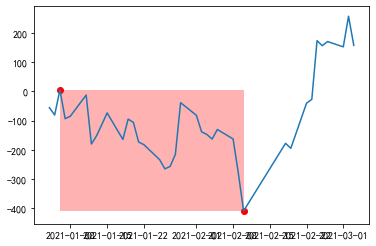

In [30]:
from wmpy.trader.utility import performance_summary
performance_summary(df, _plot=True, _print=True)

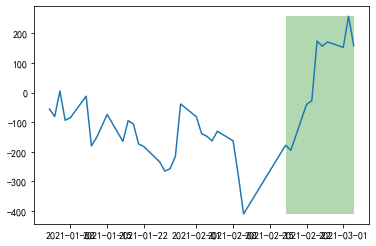

In [31]:
# 2021-2-15之后为样本外效果
import matplotlib.pyplot as plt
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 2, 15):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)